# EE 123 Lab1 - Time Domain Sonar Lab

### Written by Miki Lustig and Frank Ong 2016

In this lab, we will interact with physical time-domain signals. The first part will involve generating and recording sounds on your computer. We will use the chirp signal to characterize the response of the speaker-microphone system and look at detecting signals using cross-correlation.
In the second part, we will build on part one and use the computer sound system to develop a simple sonar.

In [1]:
# Alex Walczak
# Import functions and libraries
from __future__ import division
import numpy as np, matplotlib.pyplot as plt, bokeh.plotting as bk

import threading, time, Queue, pyaudio

from matplotlib.pyplot import *
import matplotlib.cm as cm
from scipy import signal
from numpy import *
from bokeh.models import GlyphRenderer
bk.output_notebook()
%matplotlib inline

BokehJS successfully loaded.

## Part 1: Chirping!

For this assignment you will have to use iPython, and a laptop equipped with a speaker and a microphone. When playing a sound and recording on the computer speaker, the signal goes through several systems. In particular it goes through the response of the speaker, the room we are in and the response of the microphone recording system.

A chirp is a a signal in which the frequency increases linearly with time. In this assignment we will generate a chirp signal and use it to measure the amplitude of the frequency response of our speaker-room-microphone system.

A simultaneous frequency is defined as the derivative of the phase of a signal, $f = \frac{1}{2\pi} \frac{d\phi (t)}{ dt} $. For example, the simultaneous frequency of $\cos(\phi(t))=\cos(2\pi f_0 t)$ is  

$$f = \frac{d\phi (t)}{2\pi dt}  = f_0$$ 


For a linear chirp, the frequency changes linearly over time. The simultaneous frequency is therefore defined as 

<center>$$ f(t) = f_0 + kt. $$</center>


So,  

<center>$$ x(t) = \sin(2\pi\int_0^t f(t')dt') = \sin(2\pi\int_o^t(f_0+kt')dt') = \sin(2\pi(f_0+\frac{k}{2}t)t) $$</center>


### Part I Task I: Generating the Chirp

Generate a 15 seconds long chirp signal, sampled at 44,100[Hz] with a frequency range of 20[Hz] to 20000[Hz]. Set the magnitude of the chirp to 0.5. This will help prevent non-linearities when we play the sound later. 


* Set the sample-rate frequency `fs = 44100` Hz
* Generate a time index from `t=0` to `t=15` with sampling rate of 44100 Hz
* Generate a vector of frequency vs time: `f_of_t`  (  $f(t)$ ) that changes linearly from 20Hz to 20Khz over 15 seconds
* Generate a vector of phase vs time: `phi_of_t` (  $\phi(t) = 2\pi \int_0^t f(t)dt$  ) by numerically integrating f_of_t. You will find the function `np.cumsum` useful.
* Generate the chirp function `s_chirp` with amplitude of 0.5
  
  


In [2]:
fs = 44100
# your code here

# generate time index
t = np.r_[0:15:1/fs]
# generate f_of_t
f_of_t2 = ((20*1000-20)/(15*2))*t + 20
f_of_t = ((20*1000-20)/(15))*t + 20

# generate phi_of_t
phi_of_t = 2*np.pi*np.cumsum(f_of_t, dtype=float64)

# generate chirp signal
# s_chirp = 0.5*np.sin(phi_of_t)
s_chirp = 0.5*np.sin(2*np.pi*f_of_t2*t)

* Plot the first $\frac{1}{2}$ a second of the chirp (`s_chirp`), you will notice that the carrier frequency increases and that the chirp has a constant envelope. To get a nice figure, make sure the aspect ratio of the figure is height/width = 0.2. Label the axis and figure appropriately. 

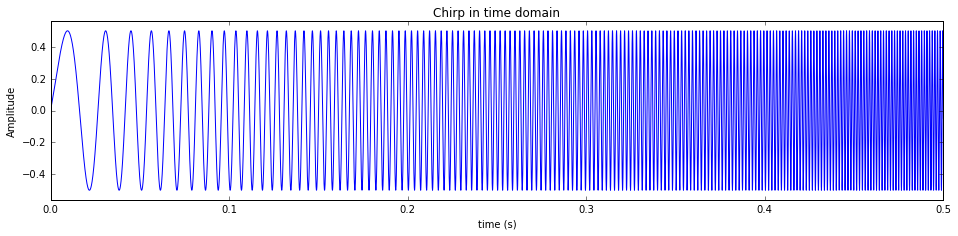

In [3]:
# Set the aspect ratio such that the image is wide
plt.figure()
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.plot(t, s_chirp)
axis([0, 0.5, -.56, .56])
plt.xlabel( "time (s)" )
plt.ylabel( "Amplitude" )
plt.title("Chirp in time domain")
#Your code below:

* Plot the magnitude frequency response of the sequence from 0 to $\pi$ using the function `signal.freqz`. Note, that the digital frequency range represents a physical frequency range of 0[hz] to 22050[Hz]. To get a nice figure, make sure the aspect ratio of the figure is height/width = 0.2. Label the axis and figure appropriately.


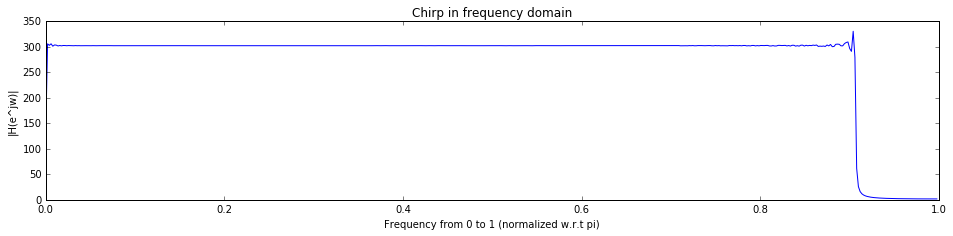

In [4]:
# generate frequency response of chirp
w, h = signal.freqz(s_chirp)
# generate frequency index
w = w/np.pi
# plot
width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.plot(w, abs(h))
plt.xlabel("Frequency from 0 to 1 (normalized w.r.t pi)")
plt.ylabel("|H(e^jw)|")
plt.title("Chirp in frequency domain")

Explain why the chirp is an appropriate signal to measure the magnitude frequency response of a system. 


#### Your answer here: 
Except for the highest of frequencies, the chirp's frequency response is approximately that of an impulse response, i.e. an all pass filter. But the chirp is easier to produce (defining an impulse response in real time can be tough). So, we can use the chirp to approximate a frequency response of a system.

* * *

### Part I Task II: Playing and Recording the Chirp
Now, we will play the sound of the chirp on our computer speaker and simultaneously record using the microphone. 

* On Apple computers it is recommended that you turn off the ambient noise reduction by going to system-preferences, selecting sound, choose the input tab and make sure that the "Use ambient noise reduction" box is unchecked. In some windows system there's ambient noise reduction as well. Make sure it is also turned off. 

* Your laptop most likely has two speakers. It is best if we work only with one. Go to the operating system's sound settings and change the stereo settings such that the speaker that is closest to the microphone is active. Your result will be much better that way. 
		
* Make sure your output volume is at 70-80% and that the laptop's microphone is on, again to avoid non-linear distorsions. 

* We will record 12 seconds just to make sure we capture the entire sequence. 

The code below defines some functions to use with pyaudio -- a multi-platform audio python interface. 

In [5]:
def play_audio( Q, p, fs , dev=None):
    # play_audio plays audio with sampling rate = fs
    # Q - A queue object from which to play
    # p   - pyAudio object
    # fs  - sampling rate
    # dev - device number
    
    # Example:
    # fs = 44100
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # Q = Queue.queue()
    # Q.put(data)
    # Q.put("EOT") # when function gets EOT it will quit
    # play_audio( Q, p, fs,1 ) # play audio
    # p.terminate() # terminate pyAudio
    
    # open output stream
    ostream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),output=True,output_device_index=dev)
    # play audio
    while (1):
        data = Q.get()
        if data is "EOT" :
            break
        try:
            ostream.write( data.astype(np.float32).tostring() )
        except:
            break
            
def record_audio( queue, p, fs ,dev=None,chunk=1024,lock=None):
    # record_audio records audio with sampling rate = fs
    # queue - output data queue
    # p     - pyAudio object
    # fs    - sampling rate
    # dev   - device number
    # chunk - chunks of samples at a time default 1024
    #
    # Example:
    # fs = 44100
    # Q = Queue.queue()
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # record_audio( Q, p, fs, 1) #
    # p.terminate() # terminate pyAudio
    
    istream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),input=True,input_device_index=dev,frames_per_buffer=chunk)

    # record audio in chunks and append to frames
    frames = [];
    while (1):
        try:  # when the pyaudio object is destroyed, stops
            with lock if lock is not None else 1:
                data_str = istream.read(chunk) # read a chunk of data
        except:
            break
        data_flt = np.fromstring( data_str, 'float32' ) # convert string to float
        queue.put( data_flt ) # append to list

def xciever(sig, fs):
    # function takes a signal and a sampling frequency
    # it then plays and records at the same time. The function returns
    # the recorded sound.

    rcv = [];

    # create an input output FIFO queues
    Qin = Queue.Queue()
    Qout = Queue.Queue()

    #lock for controlling access to shared resources
    lock = threading.Lock()
    
    # create a pyaudio object
    p = pyaudio.PyAudio()

    # initialize a recording thread.
    t_rec = threading.Thread(target = record_audio,   args = (Qin, p, fs ), kwargs={'lock': lock})
    t_play_audio = threading.Thread(target = play_audio,  args = (Qout, p, fs  ))

    # start the recording and playing threads
    t_rec.start()
    t_play_audio.start()

    Qout.put( sig );
    Qout.put( "EOT" );

    # pause for RECORD_SECS seconds
    RECORD_SECS = len(sig)/fs + 2.0
    time.sleep( RECORD_SECS )

    # terminate pyAudio
    with lock:
        p.terminate()
        
    # append to output
    while ( not Qin.empty()) :
        data = Qin.get()
        rcv = np.append( rcv, data )

    return rcv

__Playing and recording audio:__

* Run the following code. It is an example of how to play and record sound at the same time and uses threading for the play and record threads.

The resulting received sequence will be stored in the variable `rcv_chirp`.

In [6]:
## Play and record chirp at the same time

fs = 44100 # sampling rate = 44100 Hz

rcv_chirp = xciever( s_chirp, fs)

* Plot the frequency response of the received sequence. 
* Also, plot the absolute value of the received signal. Plotting the absolute value (sort of) displays the envelope of the chirp. 

Label the figures and use an aspect ratio of Height/Width = 0.2


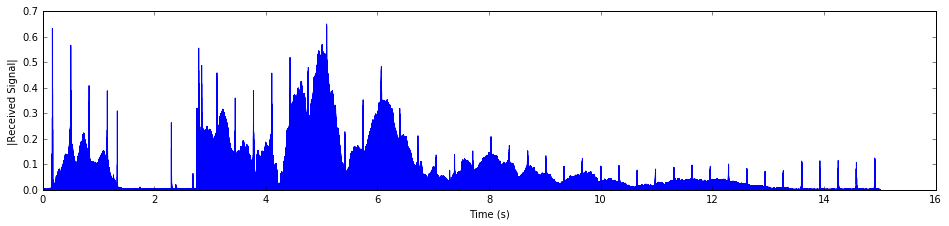

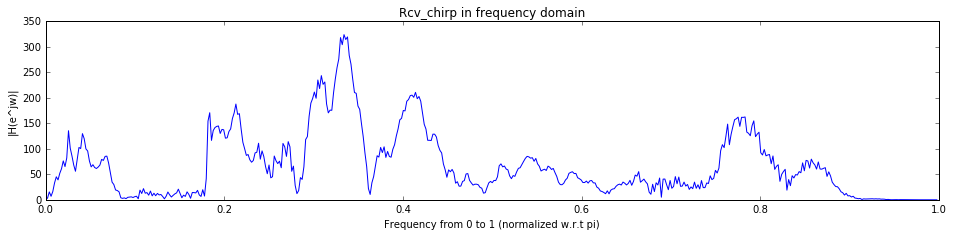

In [7]:
## Plot chirp response

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.xlabel("Time (s)")
plt.ylabel("|Received Signal|")
plt.plot(np.r_[0:15:15/len(rcv_chirp)], abs(rcv_chirp))

# generate frequency index
w, h = signal.freqz(rcv_chirp)
w = w/np.pi

# plot 2
width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.plot(w, abs(h))
plt.xlabel("Frequency from 0 to 1 (normalized w.r.t pi)")
plt.ylabel("|H(e^jw)|")
plt.title("Rcv_chirp in frequency domain")

* Comment on the results you got. In addition, what is the implicit assumption we are making in order to claim that the result is a frequency response?
(HINT: consider the case when the chirp was very short)

#### Answers here:

I sent out a chirp and got a bunch of moutain-like signals, which match the frequency response because frequency increases linearly with time, so things on the right side of rcv_chirp will be reprsented on the right, high frequency componenets of the frequency response.

Our assumption is that high frequency components do not contribute to the measured frequency response. We observed this in the frequency response of the chirp, which had a sharp cutoff around frequency = 0.9*pi. Also, we do not look at transient effects

* * *

### Part I, Task III: Envelope detection with Hilbert transform. 
The absolute value of the of the result "sort of" displays the envelope, however it is still modulated by the (now rectified) frequency sweep carrier. If we write down the response, it can be expressed approximately as 

$$y[n] = |H[n]| \sin(2\pi (f_0 +k[n*T])nT + \angle H[n])$$

where $|H[n]|$ is the frequency response for the instantaneous frequency at the nth sample and $\angle H[n]$ is its phase response. 

The reason that it is only an approximation is that there is an inherent assumption that we do not look at transient effects, only steady state effect for each frequency. This is a good approximation because our chirp is very slow compared to the propagation of sound in the room. 

One way to get the envelope $|H[n]|$ is to convert it to its analytic signal. The analytic signal $x_a(t)$ of signal $x(t)$ is:

$$x_a = F^{-1}(F(x)\cdot 2U) = x + j y$$

where $F$ is the Fourier transform, $U$ the unit step function,
and $y$ the Hilbert transform of $x$. In other words, the negative half of the frequency spectrum is zeroed
out, turning the real-valued signal into a complex signal. This is similar to the question in HW2!

The analytic signal of the received chirp will then be: 

$$ y_a[n] = |H[n]|e^{j2\pi (f_0 +k[n*T])nT + \angle H[n]} $$

The envelope can be detected by taking the magnitude. 


* Compute the analytic signal by using the function `signal.hilbert` and plot its absolute value. Note that the discrete hilbert transform is not perfect, since it uses FIR filtering. This will show up as ripple in the envelope.

* Label the figures and use an aspect ration of Height/Width = 0.2

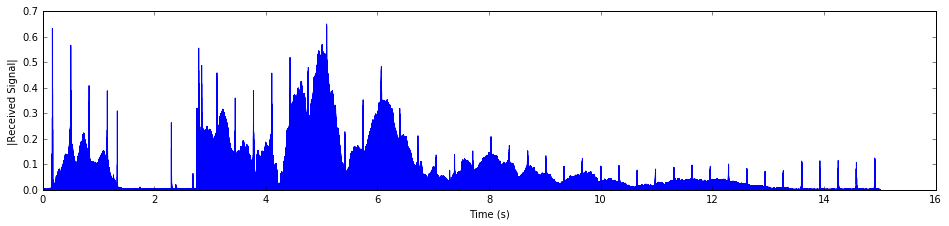

In [8]:
## Your lovely code here:

## Plot chirp response

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.xlabel("Time (s)")
plt.ylabel("|Received Signal|")
s = np.r_[0:15:15/len(rcv_chirp)]
plt.plot(s, abs(rcv_chirp))

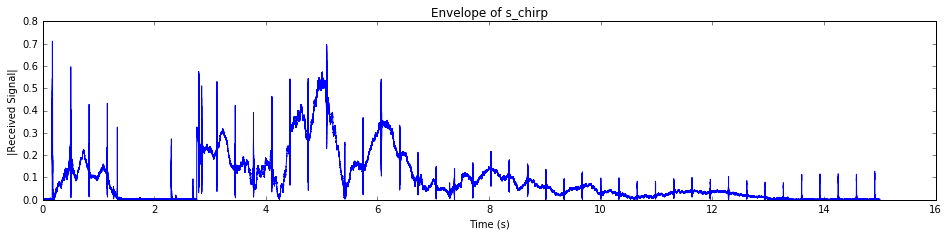

In [9]:
width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.xlabel("Time (s)")
plt.ylabel("|Received Signal|")
hil = signal.hilbert(rcv_chirp)
# plt.plot(s, abs(np.imag(hil)))
plt.plot(s, abs(hil))
plt.title("Envelope of s_chirp")

### Part I, Task IV: Auto-correlation Properties of the Chirp:

In part II of the lab, we will be sending and receiving chirp pulses to estimate delays between the tranceived pulses. This is done by cross correlating / matched filtering the received signal with the known chirp pulse to detect the echoes. In this task, we will investigate the correlation properties of the chirp.

A cross correlation is defined as:

$$ R_{xy}[n] = \sum_{m=-\infty}^\infty x[m]y^*[m-n] = (x[m]*y^*[-m])[n]$$

which is like a convolution, without flipping one of the signals. It can be implemented using a convolution as shown above. In general, the more correlated the two signals is at position $n$, the higher the value will be. That's why it is useful in a sonar system.

Because we will be doing cross-correlations between a chirp pulse and its echoes, it is useful to look at the auto-correlation, which is basically a cross correlation of the signal with itself. A discrete autocorrelation of a signal is defined as: 

$$ R_{xx}[n] = \sum_{m=-\infty}^\infty x[m]x^*[m-n] = (x[m]*x^*[-m])[n]$$ 

The chirp has a very nice property that its auto-correlation is very narrow. Since the spread of the resulting correlation determines how fast you can detect, the width of the auto-correlation is important. This property is called pulse compression and is widely considered in radar design. Random noise and some other pseudo-random like sequences also possess this property. 

* Generate a 512 sample chirp pulse with a frequency sweep from 17KHz-18KHz and sampling rate fs=44100. 
* Validate its frequency response by plotting it.

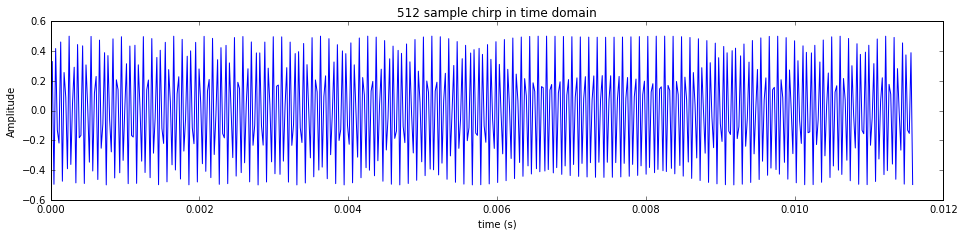

In [10]:
fs = 44100
n = 512
t = r_[0.0:n]/fs
f0 = 17000.0
f1 = 18000.0

# your code here

# generate time index

# generate f_of_t
fff = ((f1 - f0)/(2*(n/fs)))*t + f0

# generate chirp signal
chirp512 = 0.5*np.sin(2*np.pi*fff*t)

# plot
plt.figure()
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.plot(t, chirp512)
# axis([0, 0.05, -.56, .56])
plt.xlabel( "time (s)" )
plt.ylabel( "Amplitude" )
plt.title("512 sample chirp in time domain")

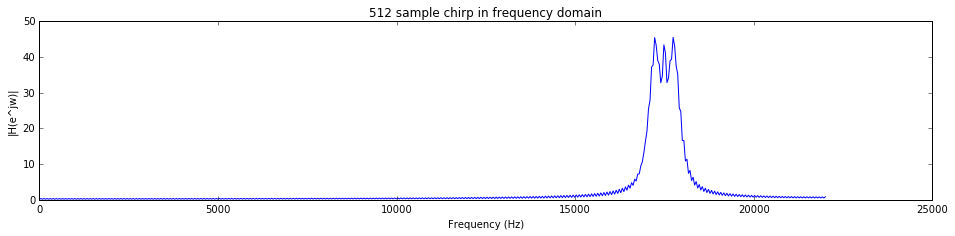

In [11]:
# generate frequency index
w, h = signal.freqz(chirp512)
w = w*22050/np.pi

# plot 2
width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.plot(w, abs(h))
plt.xlabel("Frequency (Hz)")
plt.ylabel("|H(e^jw)|")
plt.title("512 sample chirp in frequency domain")

* Compute the autocorrelation of the chirp discrete convolution, either with `signal.convolve` or `signal.fftconvolve`. Remember that you have to flip the signal since convolution does that already. You can flip a signal `x` by doing `x[::-1]`. Use mode=''full'' for convolution.
* Plot the autocorrelation. Your plot should be spiky because we did not do envolope detection yet. Use miliseconds as the x-axis

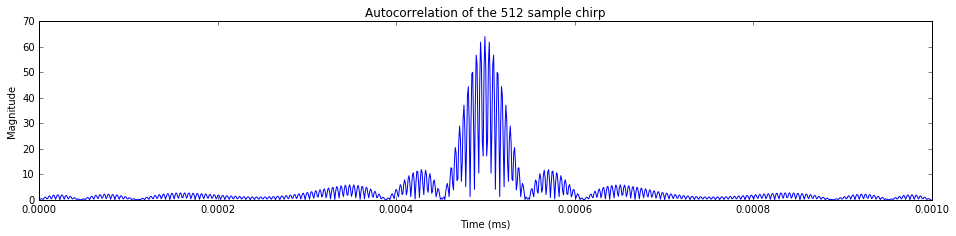

In [12]:
## Your fantastic code here:
flipped_chirp512 = chirp512[::-1]
autoc = signal.fftconvolve(chirp512, flipped_chirp512, mode = 'full')

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.plot(r_[0.0:1023]/(1000*1023), abs(autoc))
plt.xlabel("Time (ms)")
plt.ylabel("Magnitude")
plt.title("Autocorrelation of the 512 sample chirp")

In a similar way as we did before, it is possible to recover the envelope of the autocorrelation by performing a cross-correlation with the analytic signal and then taking the absolute value. In this case, we know exactly what is the analytic function is!

* Generate `s_chirp_a`, the analytic function of the chirp by computing: `s_chirp_a = exp(1j* phi_of_t )`. Perform cross correlation between `s_chirp_a` and `s_chirp` and show the envelope. This is also called a matched filter. 
* Comment on the size of the main lobe (full-width at half max) of the matched-filter with respect to the length of the pulse. That ratio is also called pulse compression. 

Use miliseconds as the x-axis



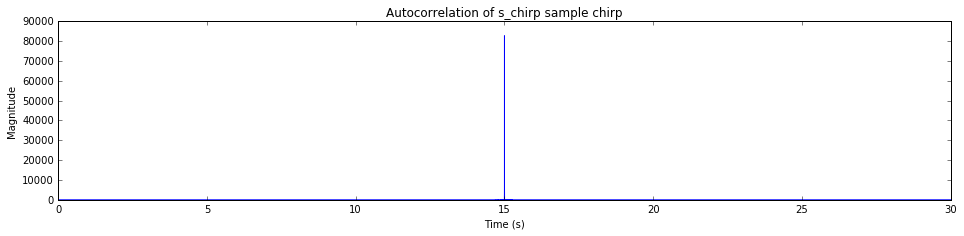

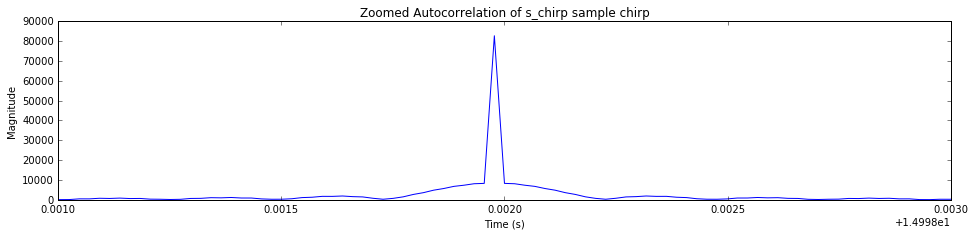

In [13]:
# your nice script to produce beautiful chirps, xcorralations and figures here:
s_chirp_a = np.exp(1j* phi_of_t)

s_chirp_flip = s_chirp[::-1]
autoc_s_chirp = signal.fftconvolve(s_chirp, s_chirp_flip, mode = 'full')

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.plot(r_[0.0:len(s_chirp)*2-1]/len(s_chirp)*15, abs(autoc_s_chirp))
plt.xlabel("Time (s)")
plt.ylabel("Magnitude")
plt.title("Autocorrelation of s_chirp sample chirp")

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.plot(r_[0.0:len(s_chirp)*2-1]/len(s_chirp)*15, abs(autoc_s_chirp))
plt.xlabel("Time (s)")
plt.ylabel("Magnitude")
axis([14.999,15.001,0,90000])
plt.title("Zoomed Autocorrelation of s_chirp sample chirp")

#### Your answer here:
The width is about 0.002 s wide. And the ratio is 15/0.002 = 7500. For the s_chirp, we would expect to have this kind of xcorrl'n because except for when everything matches up, there will be a lot of cancellation when a positive and negative signal are multiplied and summed.
___

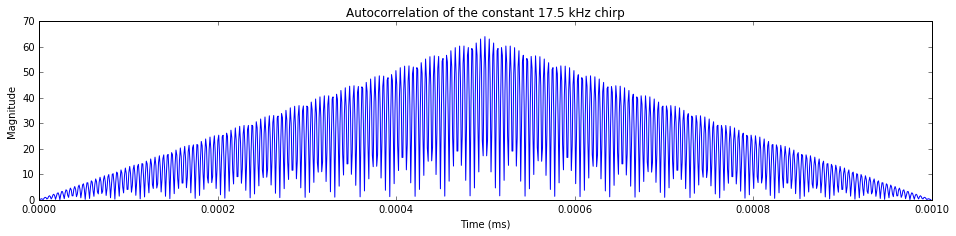

In [14]:
fs = 44100
n = 512
t = r_[0.0:n]/fs
f0 = 17500.0
f1 = 17500.0

# generate time index

# generate f_of_t
fff = ((f1 - f0)/(2*(n/fs)))*t + f0

# generate chirp signal
chirp0 = 0.5*np.sin(2*np.pi*fff*t)

## Your fantastic code here:
flipped_chirp0 = chirp0[::-1]
autoc0 = signal.fftconvolve(chirp0, flipped_chirp0, mode = 'full')

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.plot(r_[0.0:n*2-1]/(1000*(n*2-1)), abs(autoc0))
plt.xlabel("Time (ms)")
plt.ylabel("Magnitude")
plt.title("Autocorrelation of the constant 17.5 kHz chirp")

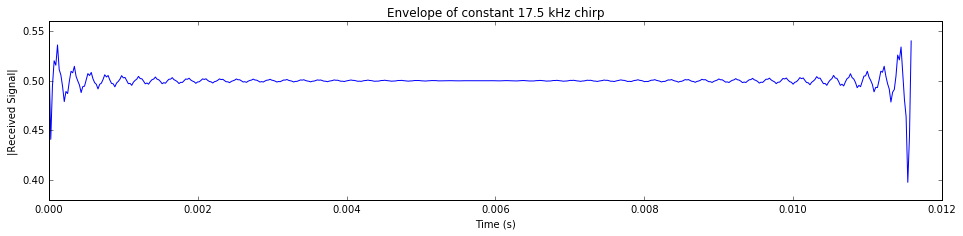

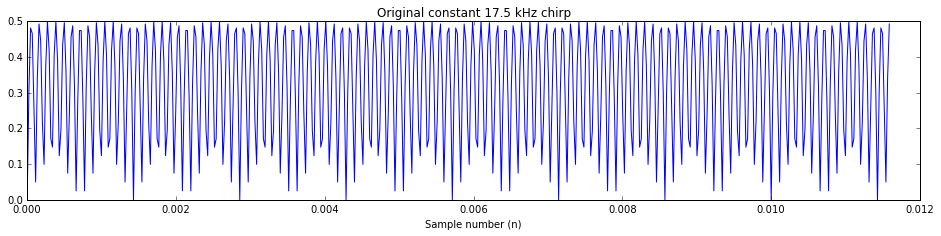

In [15]:
fs = 44100
n = 512
t = r_[0.0:n]/fs

## Plot chirp response

# width, height = plt.figaspect(0.2)
# fig = plt.figure(figsize=(width,height))
# plt.xlabel("Time (s)")
# plt.ylabel("|Received Signal|")
# plt.plot(abs(chirp0))

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.xlabel("Time (s)")
plt.ylabel("|Received Signal|")
hil0 = signal.hilbert(chirp0)
plt.plot(t, abs(hil0))
plt.title("Envelope of constant 17.5 kHz chirp")

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.xlabel("Sample number (n)")
plt.title("Original constant 17.5 kHz chirp")
plt.plot(t, abs(chirp0))

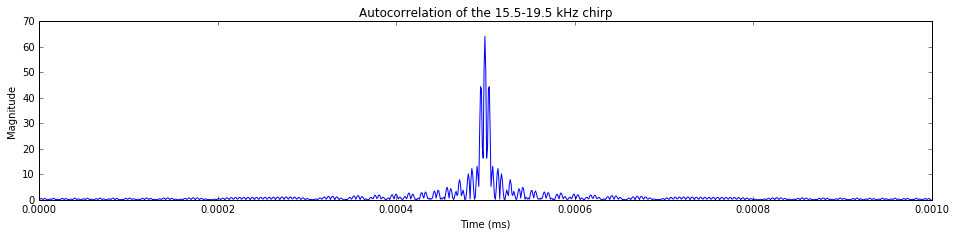

In [16]:
fs = 44100
n = 512
t = r_[0.0:n]/fs
f0 = 15500.0
f1 = 19500.0

# generate time index

# generate f_of_t
fff = ((f1 - f0)/(2*(n/fs)))*t + f0

# generate chirp signal
chirp1 = 0.5*np.sin(2*np.pi*fff*t)

## Your fantastic code here:
flipped_chirp1 = chirp1[::-1]
autoc1 = signal.fftconvolve(chirp1, flipped_chirp1, mode = 'full')

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.plot(r_[0.0:n*2-1]/(1000*(n*2-1)), abs(autoc1))
plt.xlabel("Time (ms)")
plt.ylabel("Magnitude")
plt.title("Autocorrelation of the 15.5-19.5 kHz chirp")

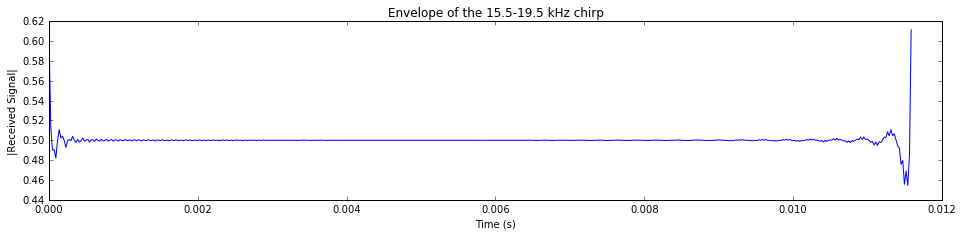

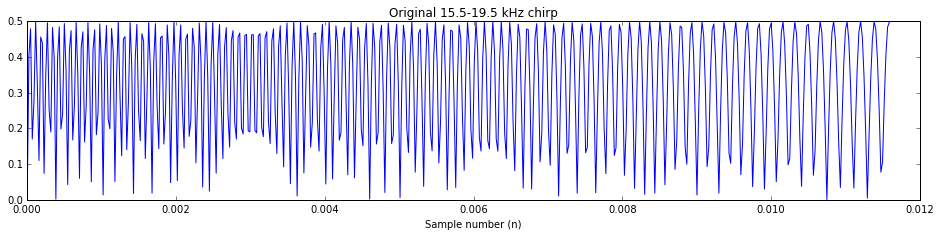

In [17]:
fs = 44100
n = 512
t = r_[0.0:n]/fs

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.xlabel("Time (s)")
plt.ylabel("|Received Signal|")
hil1 = signal.hilbert(chirp1)
plt.plot(t, abs(hil1))
plt.title("Envelope of the 15.5-19.5 kHz chirp")

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.xlabel("Sample number (n)")
plt.title("Original 15.5-19.5 kHz chirp")
plt.plot(t, abs(chirp1))

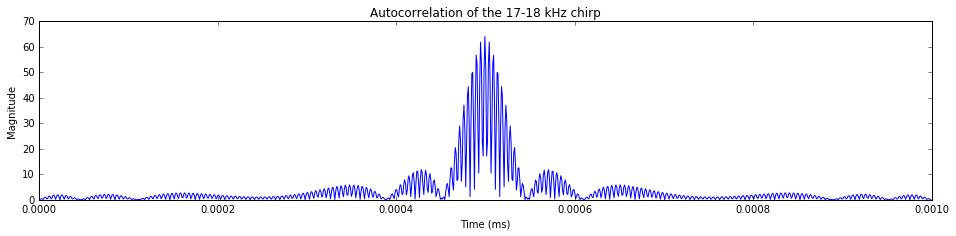

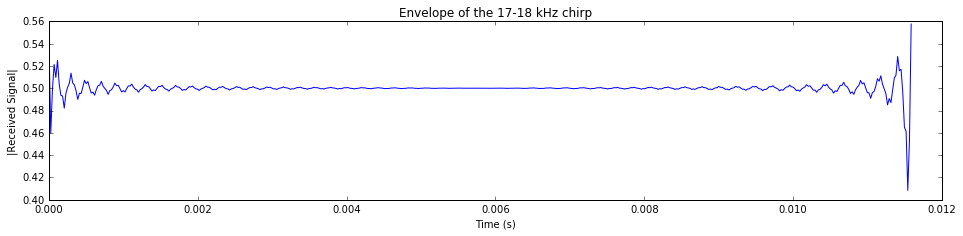

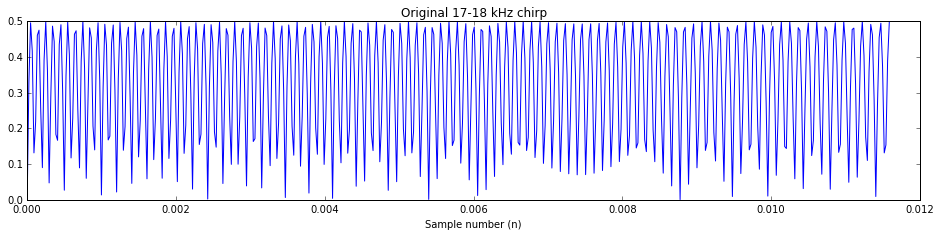

In [18]:
fs = 44100
n = 512
t = r_[0.0:n]/fs


## Your fantastic code here:
flipped_chirp512 = chirp512[::-1]
autoc512 = signal.fftconvolve(chirp512, flipped_chirp512, mode = 'full')

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.plot(r_[0.0:n*2-1]/(1000*(n*2-1)), abs(autoc512))
plt.xlabel("Time (ms)")
plt.ylabel("Magnitude")
plt.title("Autocorrelation of the 17-18 kHz chirp")


width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.xlabel("Time (s)")
plt.ylabel("|Received Signal|")
hil512 = signal.hilbert(chirp512)
plt.plot(t, abs(hil512))
plt.title("Envelope of the 17-18 kHz chirp")

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.xlabel("Sample number (n)")
plt.title("Original 17-18 kHz chirp")
plt.plot(t, abs(chirp512))

Now we will look at why the chirp pulse is better for cross-correlation detection than a pure tone.
- Repeat Task III for:
 1. A constant frequency of 17500Hz, 512 samples in length. 
 2. A chirp with a frequency sweep from 17000Hz - 18000Hz, 512 in length. 
 3. A chirp with a frequency sweep from 15500Hz - 19500Hz, 512 in length
- Compare the size of the main lobes (full width at half max). How much "Pulse Compression" are you getting by using a chirps for detection compared to a single frequency pulse?
- What is the approximate bandwidth of the pure frequency pulse and what is the bandwidth of the chirp pulses? Comment on the tradeoff between bandwidth and pulse compression

To easily zoom in to the main lobe, you can use bokeh to plot the autocorrelation:

        fig = bk.figure( title = "autocorrelation", 
                    y_axis_label = "Amplitude", x_axis_label = "t[ms]", 
                    plot_height = 300, plot_width = 800)
        fig.line( t, abs(acorr)/max(abs(acorr)), legend = 'autocorrelation', color = 'blue')
        bk.show(fig)
        
where `acorr` is the auto-correlation result and `t` is the index.

#### Your answers and interpretations here:


* * *

- Now, repeat tast III for 
 1. a chirp with a frequency sweep from 16500Hz - 18500Hz, 256 in length

- Compare the size of the main lobe (full width at half max) to the previous case of  15500Hz - 19500Hz, 512 in length.



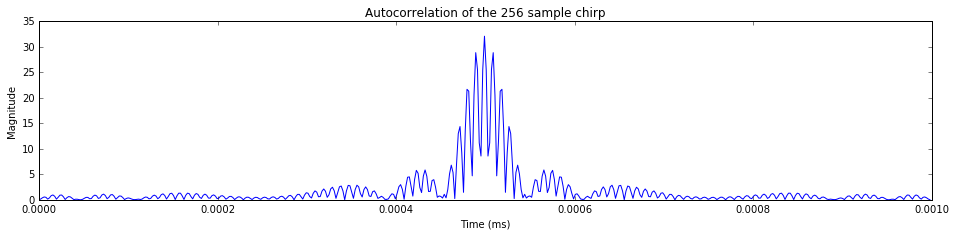

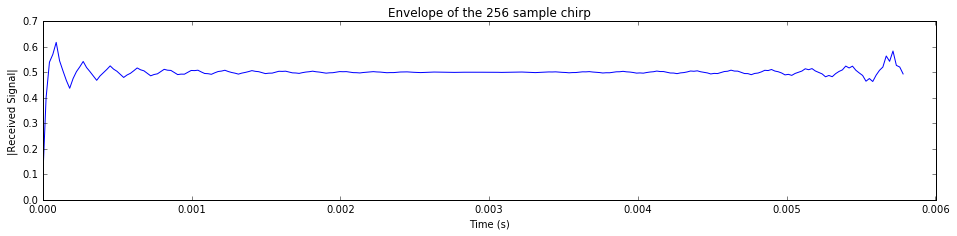

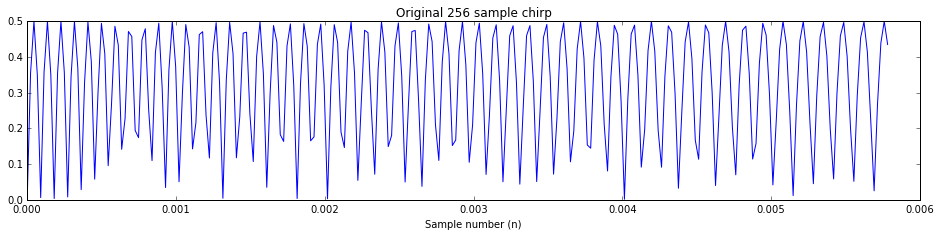

In [19]:
# your solution here

# your solution here

fs = 44100
n = 256
t = r_[0.0:n]/fs
f0 = 16500.0
f1 = 18500.0

# generate f_of_t
fff = ((f1 - f0)/(2*(n/fs)))*t + f0

# generate chirp signal
chirp256 = 0.5*np.sin(2*np.pi*fff*t)

## Your fantastic code here:
flipped_chirp256 = chirp256[::-1]
autoc256 = signal.fftconvolve(chirp256, flipped_chirp256, mode = 'full')

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.plot(r_[0.0:n*2-1]/(1000*(n*2-1)), abs(autoc256))
plt.xlabel("Time (ms)")
plt.ylabel("Magnitude")
plt.title("Autocorrelation of the 256 sample chirp")


width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.xlabel("Time (s)")
plt.ylabel("|Received Signal|")
hil256 = signal.hilbert(chirp256)
plt.plot(t, abs(hil256))
plt.title("Envelope of the 256 sample chirp")

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.xlabel("Sample number (n)")
plt.title("Original 256 sample chirp")
plt.plot(t, abs(chirp256))

#### Dealing with sidelobes
As you can see, the chirp provides good pulse compression of the main-lobe. However, there exists very strong sidelobes. This is because the chirp is multiplied with a rect function, that is abrupt. Instead, we will window the chirp with one of the smooth window functions to taper off the sidelobes. 
    

* Repeat Task 1.4.3 above for a chirp with a sweep from 17KHz to 18KHz, and from 15KHz to 20KHz. 











This time, multiply the chirp (and its analytic function) with a hanning window.  You will find the function `np.hanning` useful.  What happened to the side-lobes? What happened to the main lobe? What's the tradeoff?

* Repeat Task 1.4.3 above for a chirp with a sweep from 17KHz to 18KHz, and from 15KHz to 20KHz. 











### This time, multiply the chirp (and its analytic function) with a hanning window.  You will find the function `np.hanning` useful.  What happened to the side-lobes? What happened to the main lobe? What's the tradeoff?

* Repeat Task 1.4.3 above for a chirp with a sweep from 17KHz to 18KHz, and from 15KHz to 20KHz. 











This time, multiply the chirp (and its analytic function) with a hanning window.  You will find the function `np.hanning` useful.  What happened to the side-lobes? What happened to the main lobe? What's the tradeoff?

* Repeat Task 1.4.3 above for a chirp with a sweep from 17KHz to 18KHz, and from 15KHz to 20KHz. 











This time, multiply the chirp (and its analytic function) with a hanning window.  You will find the function `np.hanning` useful.  What happened to the side-lobes? What happened to the main lobe? What's the tradeoff?

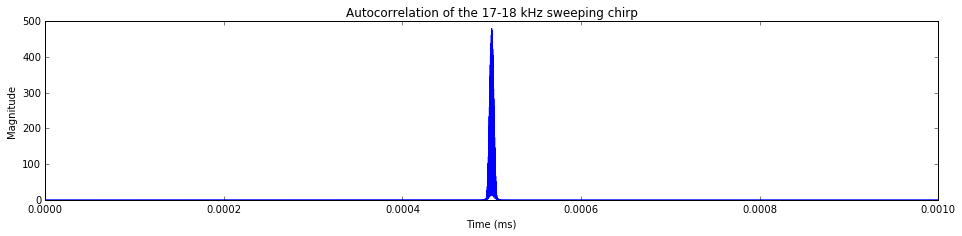

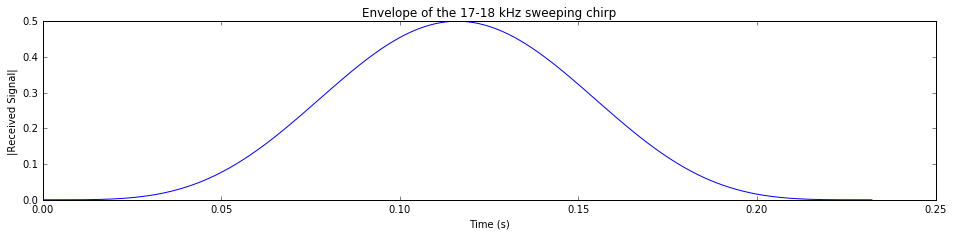

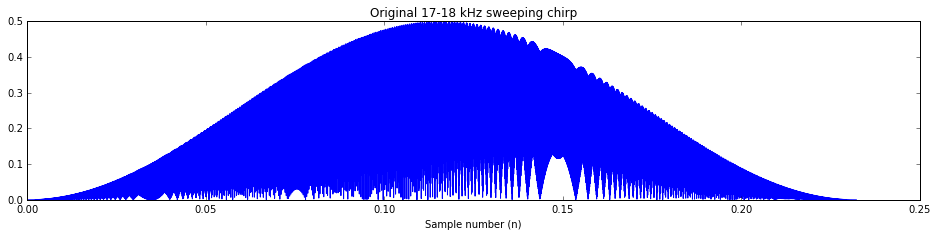

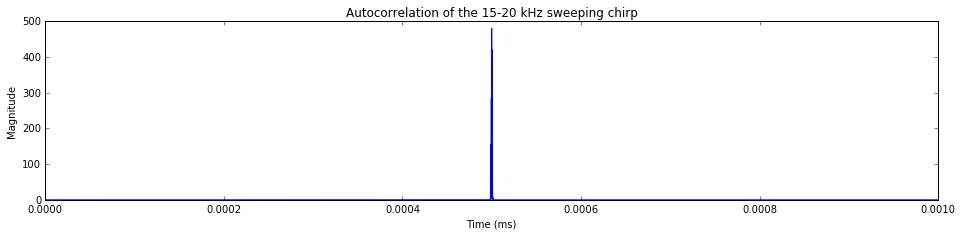

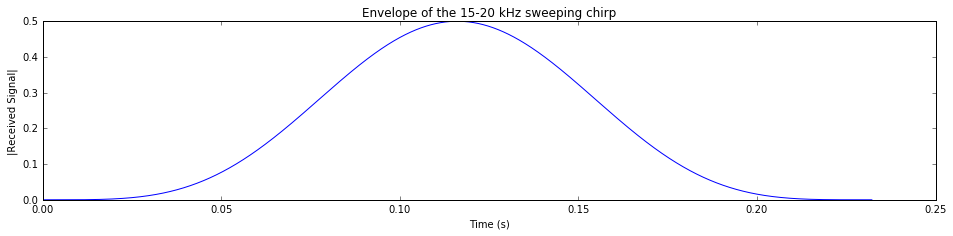

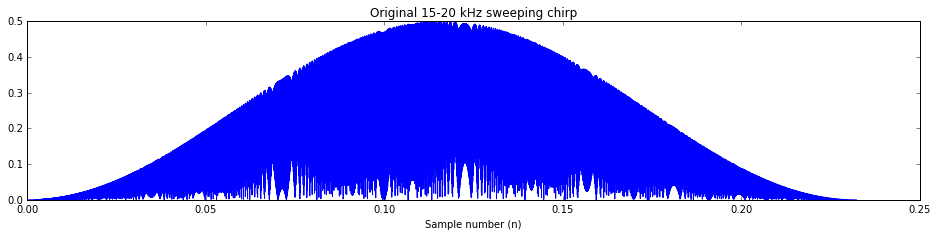

In [20]:
# your solution here

# your solution here

# your solution here

fs = 44100
n = 10240
t = r_[0.0:n]/fs
f0 = 17000.0
f1 = 18000.0

# generate f_of_t
fff = ((f1 - f0)/(2*(n/fs)))*t + f0

# generate chirp signal
chirp1780 = 0.5*np.sin(2*np.pi*fff*t)*np.hanning(n)

## Your fantastic code here:
flipped_chirp1780 = chirp1780[::-1]
autoc1780 = signal.fftconvolve(chirp1780, flipped_chirp1780, mode = 'full')

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.plot(r_[0.0:n*2-1]/(1000*(n*2-1)), abs(autoc1780))
plt.xlabel("Time (ms)")
plt.ylabel("Magnitude")
plt.title("Autocorrelation of the 17-18 kHz sweeping chirp")

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.xlabel("Time (s)")
plt.ylabel("|Received Signal|")
hil1780 = signal.hilbert(chirp1780)*np.hanning(n)
plt.plot(t, abs(hil1780))
plt.title("Envelope of the 17-18 kHz sweeping chirp")

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.xlabel("Sample number (n)")
plt.title("Original 17-18 kHz sweeping chirp")
plt.plot(t, abs(chirp1780))

# your solution here

# your solution here

# your solution here

fs = 44100
n = 10240
t = r_[0.0:n]/fs
f0 = 15000.0
f1 = 20000.0

# generate f_of_t
fff = ((f1 - f0)/(2*(n/fs)))*t + f0

# generate chirp signal
chirp1520 = 0.5*np.sin(2*np.pi*fff*t)*np.hanning(n)

## Your fantastic code here:
flipped_chirp1520 = chirp1520[::-1]
autoc1520 = signal.fftconvolve(chirp1520, flipped_chirp1520, mode = 'full')

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.plot(r_[0.0:n*2-1]/(1000*(n*2-1)), abs(autoc1520))
plt.xlabel("Time (ms)")
plt.ylabel("Magnitude")
plt.title("Autocorrelation of the 15-20 kHz sweeping chirp")

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.xlabel("Time (s)")
plt.ylabel("|Received Signal|")
hil520 = signal.hilbert(chirp1520)*np.hanning(n)
plt.plot(t, abs(hil520))
plt.title("Envelope of the 15-20 kHz sweeping chirp")

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.xlabel("Sample number (n)")
plt.title("Original 15-20 kHz sweeping chirp")
plt.plot(t, abs(chirp1520))


In [21]:
print "The side lobes shrank"

The side lobes shrank


### You are now ready to proceed to the Sonar Lab

## Part 2: Sonar

In this part of the lab we will write a simple application that implements a sonar using the laptop internal speaker and microphone. 

The basic idea is very simple and is the basis of sonar and ultrasound images -- Objects reflect sound waves. If we send a pulse of sound, we will get reflection echoes of that pulse. Detecting the echos and their time-of-flight will reveal their distance from the source, based on the speed of sound in air. 

The way we are going to implement the sonar is to generate a series of rapid pulses, and use matched filtering to detect the source and the returning echos. There are many parameters in this lab that can be tweaked to get different results. We encourage you to experiment. We enjoyed very much making the lab and played quite a bit! We hope you enjoy it too. 

Unfortunately, the quallity of the sonar system is going to be highly dependent on your laptop quallity, and the position of the speakers and microphone. It is recommended that you adjust the sound settings on your system such that only the speaker that is closer to the microphone is active. For example, MacBookAirs have the microphone on the side of the computer -- so you should set adjust the audio settings to left speaker only. Also, it is recommended that the speaker volume be set to half of its maximum to avoid non-linear distortions.  

If you are getting poor results, please consult with us. 

This lab was inspired from an iphone app called active-radar. 






### Part II, Task I: Generating Chirp Pulses

First, we will look at short chirp pulses with a pure frequency carrier. These are very common in radar and sonar systems. There are several considerations that we need to make. To be able to detect short distances, and also to be able to get good localization in time our pulses need to be very short. At the same time, shorter pulses carry less energy and have a wider bandwidth (why?). These reduce the signal to noise ratio and reduce our ability to detect targets. At the end, we will have to compromise in order to get satisfactory results in terms of detectibility and resolution. 

We are going to design a pulsed sonar system in which we repeatedly send pulses and then listen to the returning echoes. The arrival time of the echos will correspond to double the distance from a target. 

* Write a function that generates a chirp pulse:
`pulse = genChirpPulse(Npulse, f0, f1, fs)` 

The function will accept: `Npulse` = number of samples, `f0,f1` = starting and ending frequency and `fs` = sampling frequency. The function will return the analytic function of the chirp $\exp (j 2\pi \int_0^t f(t)dt )$ with amplitude 1.

In [22]:
def genChirpPulse(Npulse, f0, f1, fs):
    #     Function generates an analytic function of a chirp pulse
    #     Inputs:
    #             Npulse - pulse length in samples
    #             f0     - starting frequency of chirp
    #             f1     - end frequency of chirp
    #             fs     - sampling frequency
    #     Output:
    #              pulse - chirp pulse
    
    t = r_[0.0:Npulse]/fs

    # generate f_of_t
    fff = ((f1 - f0)/(2*(Npulse/fs)))*t + f0

    # generate chirp signal
    pulse = np.exp(1j*2*np.pi*fff*t)
    return pulse


* To validate that the function works display the pulse generated with Npulse = 200, f0=1000, f1 = 8000, fs = 44100. Remember the pulse is complex, so plot the real and imaginary part separately.

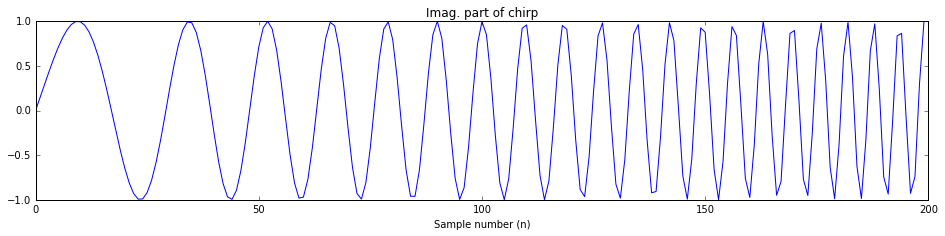

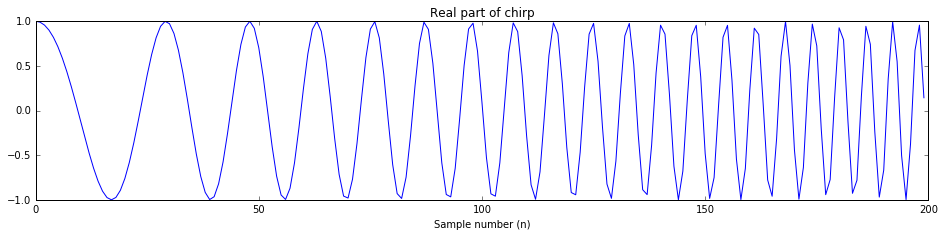

In [23]:
pulse = genChirpPulse(200, 1000, 8000, 44100)
pulse_a = genChirpPulse(200, 1000, 8000, 44100)

# your code here:
# plot
t=np.r_[0:200]

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.xlabel("Sample number (n)")
plt.title("Imag. part of chirp")
plt.plot(t, np.imag(pulse))


width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.xlabel("Sample number (n)")
plt.title("Real part of chirp")
plt.plot(t, np.real(pulse))

__Generate Pulse Trains__

Next, we will use the pulse generated by `genChirpPulse` and generate a pulse train.

* Write a new function `ptrain = genPulseTrain(pulse, Nrep, Nseg)`
The function accepts `pulse` = a pulse generated by `genChirpPulse`,  `Nrep` = number of pulse repetitions and `Nseg` = length of each pulse train segment (which is >= to the length of `pulse`).

The function returns `ptrain` which is a vector of length `Nrep` x `Nseg` (Hint: use `np.tile`)

In [24]:
def genPulseTrain(pulse, Nrep, Nseg):
    # Funtion generates a pulse train from a pulse. 
    #Inputs:
    #    pulse = the pulse generated by genChirpPulse
    #    Nrep  =  number of pulse repetitions
    #    Nseg  =  Length of pulse segment >= length(pulse)
    pulse = np.append(pulse, np.zeros(Nseg - len(pulse)))
    ptrain = np.tile(pulse, Nrep)
    return ptrain

### Part II, Task II: Echos in with Chirp pulse train

We now have components to generate pulses, generate a pulse train, play and record it. Lets see what we get!
We will start with very short pulses with a single carrier frequency. Rectangular pulses are difficult for the speaker
to produce as they exhibit discontinuities in the beginning and the end of the pulse. Therefore we will multiply the pulses
with a smooth window. Here, we will use a hanning window.

* Generate a f0=f1=15KHz, Npulse=60 pulse with fs=44100. Window the pulse with a hanning window. This will result in a pulse slightly longer than 1.5ms. You should be able to hear this tone, though most adults above 40 would not.
* Plot the real and imaginary part of the pulse

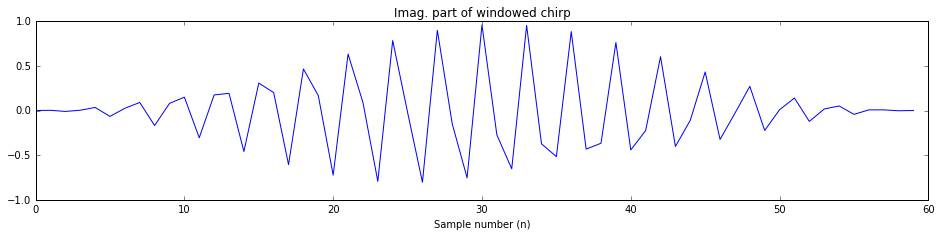

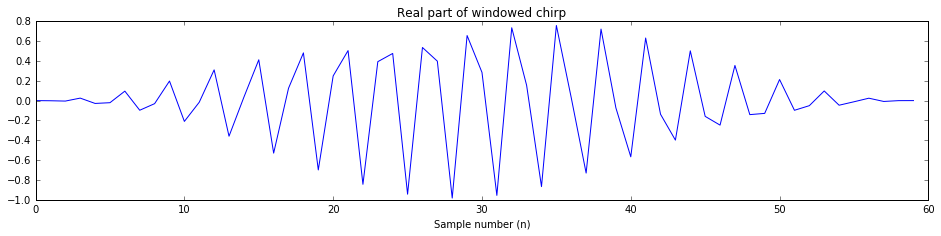

In [25]:
fs = 44100
f0 = 15000
f1 = 15000
Npulse = 60

# your code here:

Wpulse = genChirpPulse(Npulse, f0, f1, fs)*np.hanning(Npulse)

t=np.r_[0:Npulse]

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.xlabel("Sample number (n)")
plt.title("Imag. part of windowed chirp")
plt.plot(t, np.imag(Wpulse))


width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.xlabel("Sample number (n)")
plt.title("Real part of windowed chirp")
plt.plot(t, np.real(Wpulse))


#Play
# rcv_chirp = xciever(Wpulse, fs)

* Use the real part of the pulse to generate a pulse train of Nrep=15 pulses, Nseg=4096 samples

In [26]:
# your code here:

WRpulse = np.real(Wpulse)
ptrain = genPulseTrain(WRpulse, Nrep=15, Nseg=4096)

* Play and record the pulse train. Scale the amplitude of the pulses to 1/2. Make sure your volume is set to maximum of 70% and look at the plot with the input pulse train and the received pulse train. A bokeh plot cell is provided so you can zoom in to look at echoes in between.

In [27]:
rcv = xciever(ptrain / 2, fs)

In [28]:
fig = bk.figure( title = "Tranceived pulse train", 
                y_axis_label = "Amplitude", x_axis_label = "Index", 
                plot_height = 300, plot_width = 800)
fig.line( r_[:len(ptrain):10], ptrain[::10], legend = 'transmitted', color = 'orange')
fig.line( r_[:len(rcv):10], rcv[::10], legend = 'received', color = 'blue')
bk.show(fig)

* Extract a single pulse from the received pulse train. You can find the pulse index either automatically using a threshold test followed by `np.nonzero` or manually using the `bokeh` plot cell above. Extract at least 2 Npulse samples before the pulse and 20 Npulse samples after using `rcv_pulse = rcv[idx-2*Npulse:idx+Npulse*20]` 

* Plot the received pulse. Can you see any echoes?



In [29]:
# your code here:
# find index of start pulse
Npulse = 15*4096
idx = 19000
rcv_pulse = rcv[idx-10:idx+1000]
# plot
fig = bk.figure( title = "Received single pulse (start index = 19000)", 
                y_axis_label = "Amplitude", x_axis_label = "Index", 
                plot_height = 300, plot_width = 800)
fig.line( r_[:len(rcv_pulse):10], rcv_pulse[::10], legend = 'rcv_pulse', color = 'black')
bk.show(fig)
print "Looks like echoes repeat approx. every 50 samples."

Looks like echoes repeat approx. every 50 samples.


#### Matched Filtering

The strong pulses we see are a result of direct feed-through from the transmitter to the receiver that does not scatter off targets. The echoes we see are a result of echoes from reflecting surfaces. The problem in our setup is that we don't know the exact delay between the transmitter and the receive hardware (in PyAudio). Instead, we will assume that the travel time for sound between the speaker and the microphone is negligible and much smaller than scatering targets. We can then detect when the pulses start based on the direct feedthrough signal. 

We will detect both the feedthrough and echoes using matched filtering. 

* Write a function `Xrcv = crossCorr( rcv, pulse_a )` to calculate the cross correlation (matched filter) of the received signal with the analytic function of the pulse.  You can use `signal.fftconvolve`
* Take the absolute value of `Xrcv` to recover its envelope. Call the result `Xrcv_a`.

In [30]:
def crossCorr( rcv, pulse_a ):
    # Funtion generates cross-correlation between rcv and pulse_a
    # Inputs:
    #    rcv - received signal
    #    pulse_a - analytic pulse
    # Output:
    #    Xrcv - cross-correlation between rcv and pulse_a
    Xrcv = signal.fftconvolve(rcv, pulse_a[::-1])
    return Xrcv

In [31]:
Xrcv_a = abs( crossCorr(rcv, pulse_a) )

fig = bk.figure( title = "Matched filtered signal", 
                y_axis_label = "Amplitude", x_axis_label = "Index", 
                plot_height = 300, plot_width = 800)
fig.line( r_[:len(Xrcv_a):10], Xrcv_a[::10], legend = 'received', color = 'blue')
bk.show(fig)

* Again, extract a single pulse from the received pulse train using the same index. Extract at least 2 Npulse samples before the pulse and 20 Npulse samples after. Plot the received pulse. Can you see any echoes?

In [32]:
# find index of start pulse
idx = 18900

# plot
# your code here:
Npulse = 15*4096
rcv_pulse = rcv[idx-10:idx+1000]
# plot
fig = bk.figure( title = "Received single pulse (start index = 18900)", 
                y_axis_label = "Amplitude", x_axis_label = "Index", 
                plot_height = 300, plot_width = 800)
fig.line( r_[:len(rcv_pulse):10], rcv_pulse[::10], legend = 'rcv_pulse', color = 'black')
bk.show(fig)
print "Looks like an echo appears after approx. 400 samples from initial pulse."

Looks like an echo appears after approx. 400 samples from initial pulse.


#### Sonar System

In order to automate the system and visualize the results we need a few more components. To extract the pulses we need to know the position of the first feedthrough pulse. 


* Write a function `idx = findDelay(Xrcv_a, Nseg)` that takes the result of the matched filtering and finds the index of the first feedthrough pulse. Try testing on the actual signal to check whether the function is correct. There are multiple ways of doing it. `Nseg` is not required.

In [33]:
import scipy
def findDelay(Xrcv, Nseg=0):
    # finds the first pulse
    # Inputs:  
    #         Xrcv - the received matched filtered signal
    #         Nseg - length of a segment
    # Output:
    #          idx - index of the beginning of the first pulse
    of_max = 4
    pret_th = scipy.stats.threshold(Xrcv, threshmin=max(Xrcv)/of_max, newval = 0)
    th = scipy.stats.threshold(pret_th, threshmax=max(Xrcv)/of_max, newval = 1)
    
    for idx in range(len(th)):
        if th[idx]: return idx

In [34]:
idx = findDelay(Xrcv_a)
print idx

221


We now can correct for delays and detect echoes. The only thing left now is to convert the time between echoes into actual distance.

If we send a pulse of sound, we will get reflection echoes of that pulse. Detecting the echos and their time-of-flight will reveal their distance from the source, based on the speed of sound in air. The speed of sound in air is given by the following equation:

$$ v_s = 331.5\sqrt{1+T/273.15}~\mathrm{m/s}~,$$ 

where T is the temperature in degree celcius. 

* Create a function `t = dist2time( dist, temperature )` that takes in the distance to the target in cm and converts it into the time in seconds between the transmitted pulse and its echo. Remember the arrival time include the time to the target and back and therefore the time should be doubled. 
For example, for temperature = 20 celcius and dist = 400 cm, the time it takes is 0.023 secs.

In [35]:
def dist2time( dist, temperature):
    # Converts distance in cm to time in secs
    # Inputs:
    # dist        - distance to object in cm
    # temperature - in celcius
    # Output:
    # t           - time in seconds between transmitted pulse and echo
    Mdist = dist/100
    v = 331.5*np.sqrt(1 + temperature/273.17)
    return 2*Mdist/v

dist2time(400,20)

0.023295025601183472

You now have a working sonar! It would be much easier though to play with different parameters if we automate things, so we created some wrappers for real-time plotting in a separate notebook (lab1-RealTime-Sonar). 

* Copy-and-paste the 5 functions you created, including genPulseTrain(), genChirpPulse(), crossCorr(), findDelay(), and dist2time(), to the specified code cell in the real-time Sonar lab.


### You are now ready to proceed to the Real-Time Sonar Lab